In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget, ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import glob
import torch.nn as nn

In [2]:
# Load the image using PIL
images = glob.glob('../outputs/images/*/*')
sample_image = images[0]
#image = Image.open(sample_image).convert("L").resize((256, 256))
#img = np.array(image)
#img = (((img - img.min()) / img.max() - img.min())*255).astype(np.uint8)
# Stack the Gray scaled 1 channel image 3 times to convert to 3 channel image
#img = np.stack((img, )*3) 
#img = np.transpose(img, (1, 2, 0))

In [3]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)

In [4]:
input_batch.shape

torch.Size([1, 3, 256, 256])

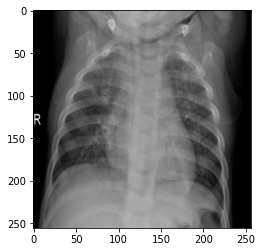

In [5]:
plt.imshow(input_batch[0, 0, :, :], cmap="gray")

In [8]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Deep Learning model (e.g., ResNet50)
DENSENET121 = models.densenet121()
DENSENET121.classifier = nn.Sequential(
        nn.Linear(in_features=(DENSENET121.classifier.in_features),out_features=512),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=512,out_features=256),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=256,out_features=128),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=128,out_features=2)
    )
model = DENSENET121
model = model.to(device)
model_config = torch.load('../models/V0/densenet121/2023-06-30 10:50:46.047269/best_model_config.pth.tar', map_location='cuda:3')
model.load_state_dict(model_config['model_weights'])
model.eval()
model.features.denseblock4.denselayer16.eval()

input_batch = input_batch.to(device)


gb_img = Image.open(sample_image).resize((256, 256))
rgb_img = np.array(rgb_img)
rgb_img = ((rgb_img - rgb_img.min()) / rgb_img.max() - rgb_img.min())

targets = [ClassifierOutputTarget(1)]
target_layers = [model.features.denseblock4.denselayer16.conv1, model.features.denseblock4.denselayer16.norm2]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_batch, targets=targets)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)

In [15]:
gb_img = Image.open(sample_image).resize((256, 256))
rgb_img = np.array(rgb_img)
rgb_img = ((rgb_img - rgb_img.min()) / rgb_img.max() - rgb_img.min())

targets = [ClassifierOutputTarget(1)]
target_layers = [model.features.denseblock4.denselayer16.conv1, model.features.denseblock4.denselayer16.norm2]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_batch, targets=targets)
    cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)

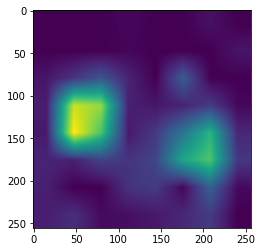

In [24]:
plt.imshow(grayscale_cams[0, :])

In [28]:
print(grayscale_cams.shape)
print(rgb_img.shape)

(1, 256, 256)
(256, 256)


In [34]:
rgb_img = Image.open(sample_image).resize((256, 256))
rgb_img = np.array(rgb_img)
rgb_img = ((rgb_img - rgb_img.min()) / rgb_img.max() - rgb_img.min())

cam_image = show_cam_on_image(rgb_img, grayscale_cams[0, :], use_rgb=True)

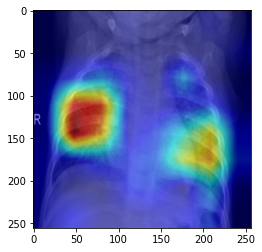

In [36]:
plt.imshow(cam_image)